# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [156]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, min, max, desc, concat, explode
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier, NaiveBayes
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [157]:
from pyspark.sql.functions import col

In [158]:
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [159]:
! spark-shell --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.3
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_265
Branch 
Compiled by user  on 2019-05-01T05:08:38Z
Revision 
Url 
Type --help for more information.


In [160]:
#set seaborn style
sns.set(style="whitegrid")

In [161]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [162]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [163]:
df.limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [164]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [165]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



- There appears to be blank user ids

In [166]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [167]:
df.count()

286500

In [168]:
for col_ in df.columns:
    print(col_,df.filter(col(col_).isNull()).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 0


In [169]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [170]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [171]:
df.dropDuplicates().count()

286500

In [172]:
df.filter(col("userId") == "" ).count()

8346

In [173]:
## Clean empty user id's
df = df.filter(df.userId!="")
df.count()

278154

In [174]:
#observation:no duplicates

In [175]:
#stats:

In [176]:
stats_df = df.describe().toPandas().set_index("summary")
all_stats =spark.createDataFrame(stats_df.reset_index()).cache()
stats_df

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
summary,,,,,,,,,,,,,,,,,,
count,228108,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154
mean,551.0852017937219,None,None,None,114.89918174824018,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1042.5616241362698,Infinity,209.10321620397335,1.5409589154318713E12,None,59682.02278593872
stddev,1217.7693079161374,None,None,None,129.851729399489,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.5010362219813,NaN,30.151388851328214,1.5068287123306298E9,None,109091.9499991047
min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [177]:
df.filter( col("userId") == ""  ).count()

0

In [178]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df_cleaned = df.withColumn("time", get_time(df.ts))

In [179]:
df_cleaned.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16


In [180]:
df_cleaned.createOrReplaceTempView("Sparkify_local_cleaned")

In [181]:
spark.sql('''
        SELECT DISTINCT(auth)
        FROM Sparkify_local_cleaned
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [182]:
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY auth
        ORDER BY user_counts DESC
''').show()

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



In [183]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



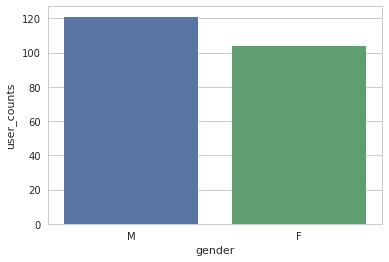

In [184]:

sns.barplot(x='gender',y='user_counts',data=gender_count.toPandas());

In [185]:
spark.sql('''
        SELECT count(*)
        FROM Sparkify_local_cleaned
        where userid != ''
''').show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



In [186]:
spark.sql('''
        SELECT count(*)
        FROM Sparkify_local_cleaned
        where userid = ''
''').show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [187]:
df2 = spark.sql('''
        SELECT *
        FROM Sparkify_local_cleaned
        where userid != ''
''')

In [188]:
df2.count()

278154

In [189]:
df2.createOrReplaceTempView("Sparkify_local_cleaned2")

In [190]:
spark.sql('''
        SELECT COUNT(DISTINCT(itemInSession)) AS item_counts
        FROM Sparkify_local_cleaned2
''').show()

+-----------+
|item_counts|
+-----------+
|       1311|
+-----------+



In [191]:
length_data = spark.sql('''
        SELECT length
        FROM Sparkify_local_cleaned2
''')

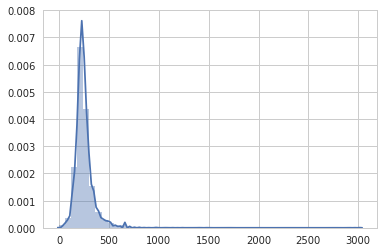

In [192]:
sns.distplot(length_data.toPandas().dropna());

In [193]:
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned2
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



In [194]:
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned2
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()

In [195]:

#split city and state
location_count = location_count.join(location_count['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)

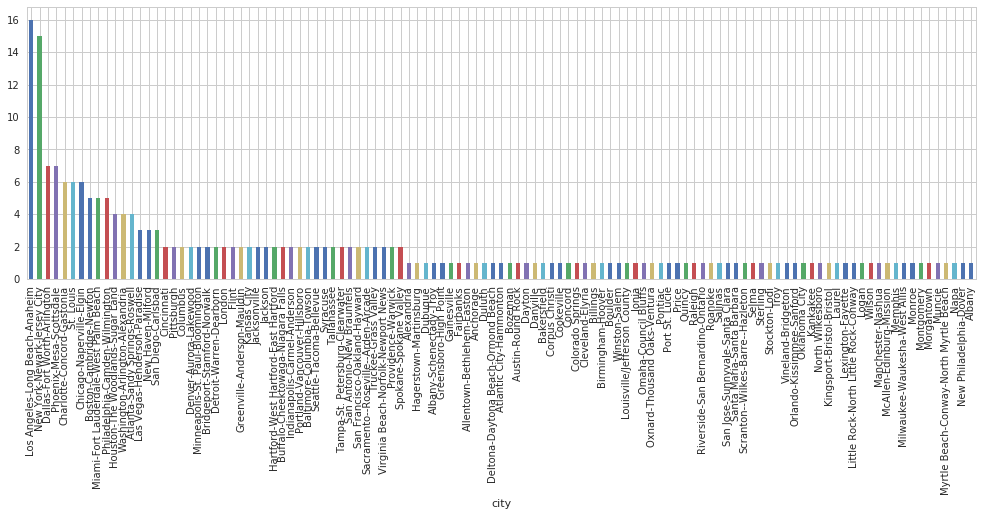

In [196]:
location_count.groupby('city')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

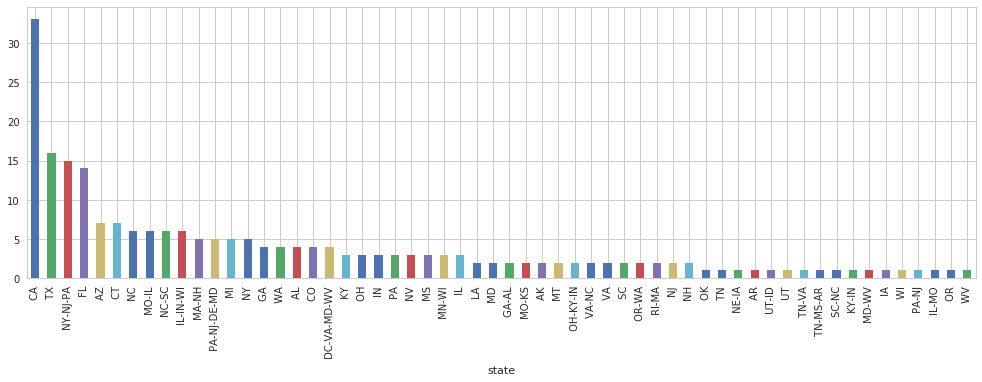

In [197]:
location_count.groupby('state')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

In [198]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [199]:
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM Sparkify_local_cleaned2
        GROUP BY page
        ORDER BY user_counts DESC
''').toPandas()

,page,user_counts
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


In [200]:
userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned2
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').toPandas()

In [201]:

def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [202]:
userAgent_count['browser'] = userAgent_count['userAgent'].apply(get_browser)

In [203]:
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [204]:
userAgent_count['platform'] = userAgent_count['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)

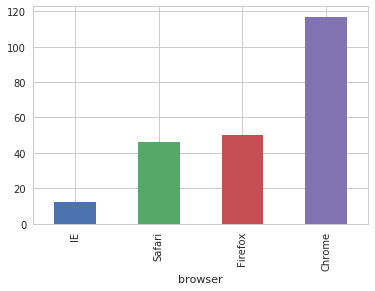

In [205]:

userAgent_count.groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar');

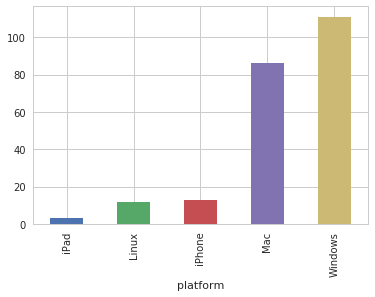

In [206]:
userAgent_count.groupby('platform')['user_counts'].sum().sort_values().plot(kind='bar');


In [207]:
time_data = spark.sql('''
        SELECT time,userId
        FROM Sparkify_local_cleaned2
''').toPandas()

In [208]:
time_data['time'] = pd.to_datetime(time_data['time'])

In [209]:
weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_data['weekday'] = time_data['time'].dt.weekday.map(weekday_dict)
time_data['day'] = time_data['time'].dt.day
time_data['hour'] = time_data['time'].dt.hour

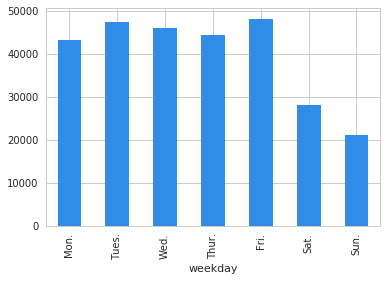

In [210]:
time_data.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar',color='#318ce7');

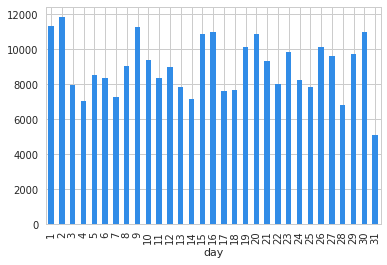

In [211]:
time_data.groupby('day')['userId'].count().plot(kind='bar',color='#318ce7');

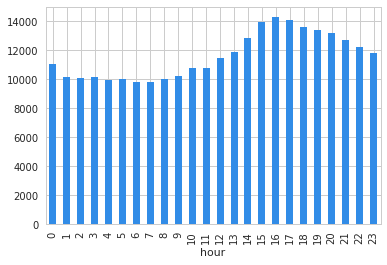

In [212]:
time_data.groupby('hour')['userId'].count().plot(kind='bar',color='#318ce7');

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [213]:
df_cleaned_cancel.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [215]:

df_cleaned_cancel.filter(df_cleaned_cancel.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



In [216]:
df_cleaned_cancel.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df_cleaned_cancel.userId == "125").sort("time").show(50)

+------+--------------------+-------------------+-----+--------------------+---------+
|userId|                page|               time|level|                song|sessionId|
+------+--------------------+-------------------+-----+--------------------+---------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|      174|
|   125|            NextSong|2018-10-12 04:32:08| free|     They're Red Hot|      174|
|   125|            NextSong|2018-10-12 04:35:06| free|                Kota|      174|
|   125|         Roll Advert|2018-10-12 04:

- Add Churn Column

In [219]:
churn_users = df_cleaned_cancel.filter(df_cleaned_cancel.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df_cleaned_cancel.withColumn("churn", df_cleaned_cancel.userId.isin(churn_users_list))

In [220]:
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
|false|  null|    1|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



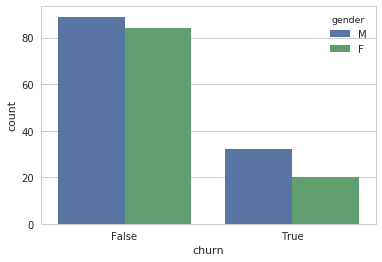

In [221]:
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd);

In [222]:
#define the current churn or not state
df_cleaned_cancel = df_cleaned.withColumn('Churn_state',flag_event('page'))

In [223]:
churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

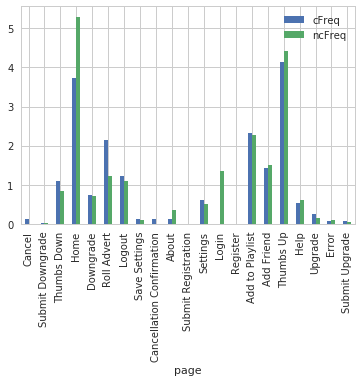

In [224]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page");

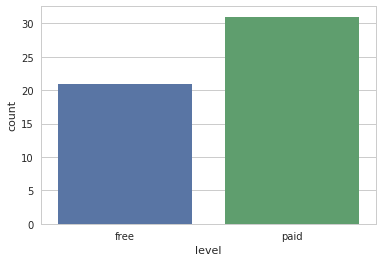

In [225]:
df_pd = df_withchurn.filter(df_withchurn.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd);

In [226]:
df_withchurn.select("time").describe().show()

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             286500|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



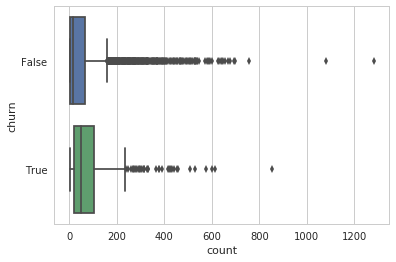

In [227]:
df_pd = df_withchurn.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn', orient="h", data=df_pd);

In [228]:

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_withchurn = df_withchurn.withColumn("hour", get_hour(df_withchurn.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_withchurn = df_withchurn.withColumn("weekday", get_weekday(df_withchurn.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_withchurn = df_withchurn.withColumn("day", get_day(df_withchurn.ts))

In [229]:

def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = df_withchurn.filter(df_withchurn.page == "NextSong").groupby("churn", time).count().orderBy(df_withchurn[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn==0].plot.bar(x=time, y='count', color='Blue', label='Not churn')
    df_pd[df_pd.churn==1].plot.bar(x=time, y='count', color='Red', label='Churn')

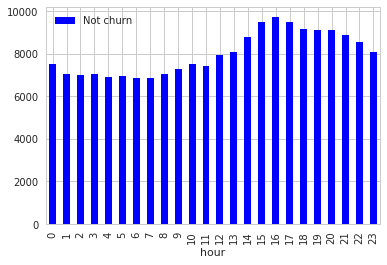

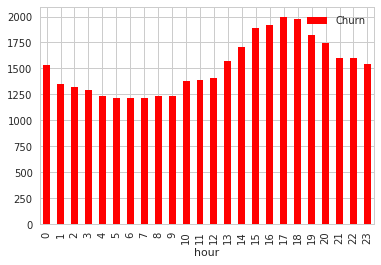

In [230]:
plot_cnt_by_churn("hour")

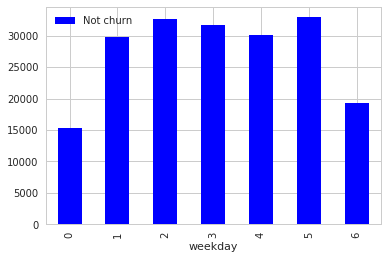

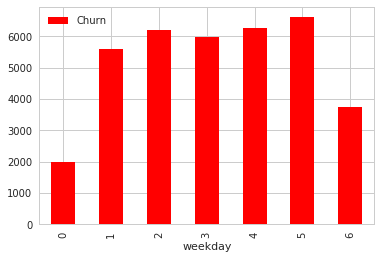

In [231]:
plot_cnt_by_churn("weekday")

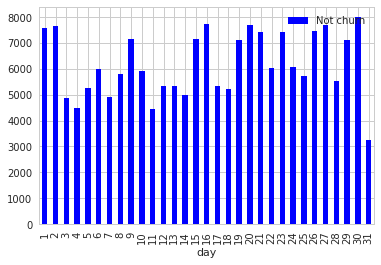

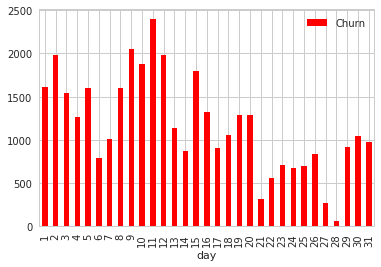

In [232]:
plot_cnt_by_churn("day")

In [233]:
## check for NULLs or Blanks

##Find count of null & empty string for user id


df_withchurn.filter(col("userId") == "" ).count()



8346

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

- Feature 1: number of days since registration

In [234]:
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [235]:
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



- Feature 2: avg & min & max time per session

In [236]:
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")

In [237]:
user_session_time_stat.show(5)

+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|      | 5838.938684264373|              0.0|          84056.45|
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
+------+------------------+-----------------+------------------+
only showing top 5 rows



- Feature 3: number of songs per session

In [238]:
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")

In [239]:

user_session_songs_avg.show(10)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
|100004|              47.1|
|100005|              38.5|
|100006|              26.0|
|100007|              47.0|
|100008|128.66666666666666|
+------+------------------+
only showing top 10 rows



- Feature 4: number of sessions

In [240]:
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")

In [241]:
user_session_count.show(5)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



- Feature 5: gender

In [242]:
user_gender = df_withchurn.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

In [243]:
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



- Feature 6: whether the user is currently a paid user

In [244]:
user_paid = df_withchurn.groupby("userId", "level").agg(max(df_withchurn.ts).alias("finalTime")).sort("userId")


In [245]:
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))
user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))

In [246]:
user_recent_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|      |    1|
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
+------+-----+
only showing top 5 rows



- Feature 7: frequency of use of pages

In [247]:
# get all the type of page
page_list = [(row['page']) for row in df_withchurn.select("page").dropDuplicates().collect()]

# must remove the column which will cause data leakage
page_list.remove("Cancel")
page_list.remove("Cancellation Confirmation")

# caculate the total page each user view
user_page_view_count = df_withchurn.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "pageCount")


for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = df_withchurn.filter(df_withchurn.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userIdTemp, "left").drop("userIdTemp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)

In [248]:
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_freq = spark.sql(freq_sql)

In [249]:
user_page_view_freq.show(5)

+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+----------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+
|userId| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|freqSubmitRegistration|       freqSettings|         freqLogin|       freqRegister| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|
+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+----------------------+----

- Feature 8: how many singers have the user heard

In [250]:
user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")

In [251]:
user_artist_count.show(5)

+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



- Label: churn

In [252]:
user_churn = df_withchurn.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))

In [253]:
user_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



In [254]:
# put all the features dataframe into a list
features_list = []
features_list.append(user_reg_days)
features_list.append(user_session_time_stat)
features_list.append(user_session_songs_avg)
features_list.append(user_session_count)
features_list.append(user_gender)
features_list.append(user_recent_level)
features_list.append(user_page_view_freq)
features_list.append(user_artist_count)
features_list.append(user_churn)

In [255]:

# prepare the final dataframe to join all the other features
df_final = df_withchurn.select("userId").dropDuplicates()

In [256]:

def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [257]:
# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)

In [258]:
# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.persist()
df_final.show(5)

+------+------------------+------------------+-----------------+------------------+------------------+------------+------+-----+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+----------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+-----------+-----+
|userId|            regDay|    avgSessionTime|   minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|level| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|freqSubmitRegistration|       freqSettings|         freqLogin|       freqRegister| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHe

In [259]:
df_final.columns

['userId',
 'regDay',
 'avgSessionTime',
 'minSessionTime',
 'maxSessionTime',
 'avgSessionSongs',
 'sessionCount',
 'gender',
 'level',
 'freqSubmitDowngrade',
 'freqThumbsDown',
 'freqHome',
 'freqDowngrade',
 'freqRollAdvert',
 'freqLogout',
 'freqSaveSettings',
 'freqAbout',
 'freqSubmitRegistration',
 'freqSettings',
 'freqLogin',
 'freqRegister',
 'freqAddtoPlaylist',
 'freqAddFriend',
 'freqNextSong',
 'freqThumbsUp',
 'freqHelp',
 'freqUpgrade',
 'freqError',
 'freqSubmitUpgrade',
 'aritstCount',
 'churn']

In [260]:
df_final.persist()

DataFrame[userId: string, regDay: double, avgSessionTime: double, minSessionTime: double, maxSessionTime: double, avgSessionSongs: double, sessionCount: bigint, gender: int, level: int, freqSubmitDowngrade: double, freqThumbsDown: double, freqHome: double, freqDowngrade: double, freqRollAdvert: double, freqLogout: double, freqSaveSettings: double, freqAbout: double, freqSubmitRegistration: double, freqSettings: double, freqLogin: double, freqRegister: double, freqAddtoPlaylist: double, freqAddFriend: double, freqNextSong: double, freqThumbsUp: double, freqHelp: double, freqUpgrade: double, freqError: double, freqSubmitUpgrade: double, aritstCount: bigint, churn: int]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [261]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  174|
+-----+-----+



In [262]:

out_path = "final_data2.csv"
df_final.write.save(out_path, format="csv", header=True)

In [ ]:
df_final = spark.read.csv(out_path, header=True)
df_final.persist()

In [263]:
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [266]:
assembler = VectorAssembler(inputCols=df_final.columns[1:-1], outputCol="NumFeatures")
data = assembler.setHandleInvalid("skip").transform(df_final)

In [267]:

scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [268]:
data = data.select(data.churnNum.alias("label"), data.ScaledNumFeatures.alias("features"))

In [269]:
train, validation = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [270]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval.fit(train)

KeyboardInterrupt: 

In [ ]:
cvModel_lr.save('cvModel_lr.model')

In [ ]:
cvModel_lr.avgMetrics

### Decision Tree Classifier

-  When using decision trees for classification, you'll build up an ML-based classifier after the training fields, feed in the input features, and in response get whether that person is likely to churn or not. This is your output classification label.
-  When you're constructing your decision tree model, you can choose one of two ways in which to measure the impurity of the node.
- The objective of a classification decision tree that we build up is to minimize the Gini/Entropy impurity at each node
- Gini impurity is found from rule violations in training data. The measure of Gini impurity is on the training data, not on predictions. 
- The one hyperparameter that decision trees use is the depth of the tree that it constructs. Shallower trees result in fewer decision variables.

#### Decision Tree Drawbacks
- Decision trees are highly prone to overfitting, meaning that your model performs extremely well on training data, but does not perform well on test data perform very well on test data, or in the real world.
- Small changes in data cause big changes in model. models which are very sensitive to the training data are said to be high variance models.

In [272]:

dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

cvModel_dt = crossval_dt.fit(train)

In [273]:
cvModel_dt.save('cvModel_dt.model')

In [274]:
cvModel_dt.avgMetrics

[0.7416321292641614,
 0.7458901873735065,
 0.7599698216909568,
 0.7889360182881016,
 0.7599010760062006,
 0.7616017885873085]

In [ ]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)

In [ ]:
cvModel_gbt.save('cvModel_gbt.model')

In [ ]:
cvModel_gbt.avgMetrics

- 
Use undersampling to optimize the F1 score

In [ ]:

stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
stratified_train.groupby("label").count().show()

In [ ]:
lrs =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lrs.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lrs.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval_lrs = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lrs = crossval_lrs.fit(stratified_train)
cvModel_lrs.avgMetrics

In [ ]:
cvModel_lrs.save('cvModel_lrs.model')

In [ ]:
dts = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dts.impurity,['entropy', 'gini']) \
    .addGrid(dts.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()
crossval_dts = CrossValidator(estimator=dts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_dts = crossval_dts.fit(stratified_train)
cvModel_dts.avgMetrics

In [ ]:
cvModel_dts.save('cvModel_dts.model')

In [ ]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[3, 10, 20]) \
    .addGrid(gbts.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_gbts = crossval_gbts.fit(stratified_train)
cvModel_gbts.avgMetrics

In [ ]:
cvModel_gbts.save('cvModel_gbts.model')

- Use the validate data to evaluate the best model through F1 score.

In [ ]:
results = cvModel_lr.transform(validation)

In [ ]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

In [ ]:
results = cvModel_lrs.transform(validation)

In [ ]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

In [ ]:
cvModel_lrs.bestModel.coefficients

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.